In [120]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import re
import nltk
from sklearn.decomposition import PCA
from sklearn.preprocessing import LabelEncoder
from nltk.tokenize import word_tokenize
from nltk.corpus import stopwords
from sklearn.model_selection import train_test_split
import tensorflow as tf
from tensorflow.keras.models import load_model
from sklearn.metrics import classification_report
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import accuracy_score
from sklearn.metrics import f1_score
from sklearn.metrics import accuracy_score, f1_score, classification_report
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import confusion_matrix
import seaborn as sns
from sklearn.model_selection import KFold, StratifiedKFold, cross_val_score, learning_curve
nltk.download('punkt')
nltk.download('wordnet')
nltk.download('stopwords')
from sklearn.feature_extraction.text import TfidfVectorizer

import warnings
warnings.filterwarnings('ignore')

[nltk_data] Downloading package punkt to
[nltk_data]     C:\Users\DELL\AppData\Roaming\nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package wordnet to
[nltk_data]     C:\Users\DELL\AppData\Roaming\nltk_data...
[nltk_data]   Package wordnet is already up-to-date!
[nltk_data] Downloading package stopwords to
[nltk_data]     C:\Users\DELL\AppData\Roaming\nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


In [121]:
df = pd.read_csv(r'data.csv')

In [122]:
df.head()

,overall,verified,reviewerID,product,productID,reviewText,unixReviewTime
0,5,1,A30VYJQW4XWDQ6,"AGELESS™: UltraMAX Gold™ Capsules, HGH Anti-Ag...",B0011FYB5I,"Made me look older, it was the opposite.",1472692083
1,5,1,A30VYJQW4XWDQ6,"AGELESS™: UltraMAX Gold™ Capsules, HGH Anti-Ag...",B0011FYB5I,Works good with exercise.,1472690218
2,5,1,A28F08XFZRKIH5,All Natural Deodorant for Women & Men. Organic...,B01DKQAXC0,"great smell, and work better than the bad stuf...",1472692009
3,3,1,A157AUOFPJQ46Q,"American Crew Body Wash for Men, Tea Tree Leaf...",B000X7ST9Y,I don't understand the bad reviews because thi...,1472690166
4,5,1,A2USMIT2CSA08,"Andalou Naturals, Toner Facial Toner Helps Hyd...",B0091OCA86,Smells amazing and does a good job of refreshi...,1472691711


## Text preprocessing

In [123]:
df.drop('product', axis=1, inplace=True)
df.drop('unixReviewTime', axis=1, inplace=True)
df

,overall,verified,reviewerID,productID,reviewText
0,5,1,A30VYJQW4XWDQ6,B0011FYB5I,"Made me look older, it was the opposite."
1,5,1,A30VYJQW4XWDQ6,B0011FYB5I,Works good with exercise.
2,5,1,A28F08XFZRKIH5,B01DKQAXC0,"great smell, and work better than the bad stuf..."
3,3,1,A157AUOFPJQ46Q,B000X7ST9Y,I don't understand the bad reviews because thi...
4,5,1,A2USMIT2CSA08,B0091OCA86,Smells amazing and does a good job of refreshi...
...,...,...,...,...,...
4216,5,0,A3E5V5TSTAY3R9,B0006O10P4,This is the best smelling soap I've ever found...
4217,5,0,A3E5V5TSTAY3R9,B0006O10P4,This is the best smelling soap I've ever found...
4218,5,0,A281NPSIMI1C2R,B0006O10P4,"Warm, soothing and a little spicy. This zum ba..."
4219,5,1,A3E5V5TSTAY3R9,B0006O10P4,I decided to SPLURGE ($8.98 for a 3 oz. bar) a...


In [124]:
def remove_bullet_points(text):
    bullet_point_pattern = re.compile(r'\s*[\u2022\u2023\u25E6]\s*') 
    cleaned_text = bullet_point_pattern.sub(' ', text)

    return cleaned_text

In [125]:
def remove_emojis_and_symbols_from_text(text):
    # Define pattern to match emojis
    emoji_pattern = re.compile("["
                           u"\U0001F600-\U0001F64F"  # emoticons
                           u"\U0001F300-\U0001F5FF"  # symbols & pictographs
                           u"\U0001F680-\U0001F6FF"  # transport & map symbols
                           u"\U0001F1E0-\U0001F1FF"  # flags (iOS)
                           u"\U00002500-\U00002BEF"  # chinese char
                           u"\U00002702-\U000027B0"
                           u"\U00002702-\U000027B0"
                           u"\U000024C2-\U0001F251"
                           u"\U0001f926-\U0001f937"
                           u"\U00010000-\U0010ffff"
                           u"\u2640-\u2642"
                           u"\u2600-\u2B55"
                           u"\u200d"
                           u"\u23cf"
                           u"\u23e9"
                           u"\u231a"
                           u"\ufe0f"  # dingbats
                           u"\u3030"
                           u"\u00ae" # trade Marks ®
                           u"\u00A9" # copy Right ©
                           u"\u2122" # Trade Mark TM
                           u"\u200b"
                           "]+", flags=re.UNICODE)
    # Remove emojis from the text
    cleaned_text = emoji_pattern.sub(r' ', text)
    return cleaned_text

In [126]:
def decontraction(x):
    contractions = {
        "you've": 'you have',
        "you're": 'you are',
        "haven't": 'have not',
        "hasn't": 'has not',
        "hadn't've": 'had not have',
        "hadn't": 'had not',
        "don't": 'do not',
        "doesn't": 'does not',
        "didn't": 'did not',
        "couldn't've": 'could not have',
        "couldn't": 'could not',
        "could've": 'could have',
        "'cause": 'because',
        "can't've": 'cannot have',
        "aren't": 'are not',
        "ain't": 'am not',
        "can't": 'can not',
        "won't": 'will not',
        "he'd": 'he would',
        "he'd've": 'he would have',
        "he'll": 'he will',
        "he'll've": 'he will have',
        "he's": 'he is',
        "how'd": 'how did',
        "how'd'y": 'how do you',
        "how'll": 'how will',
        "how's": 'how does',
        "i'd": 'i would',
        "i'd've": 'i would have',
        "i'll": 'i will',
        "i'll've": 'i will have',
        "i'm": 'i am',
        "i've": 'i have',
        "isn't": 'is not',
        "it'd": 'it would',
        "it'd've": 'it would have',
        "it'll": 'it will',
        "it'll've": 'it will have',
        "it's": 'it is',
        "let's": 'let us',
        "ma'am": 'madam',
        "mayn't": 'may not',
        "might've": 'might have',
        "mightn't": 'might not',
        "mightn't've": 'might not have',
        "must've": 'must have',
        "mustn't": 'must not',
        "mustn't've": 'must not have',
        "needn't": 'need not',
        "needn't've": 'need not have',
        "o'clock": 'of the clock',
        "oughtn't": 'ought not',
        "oughtn't've": 'ought not have',
        "shan't": 'shall not',
        "sha'n't": 'shall not',
        "shan't've": 'shall not have',
        "she'd": 'she would',
        "she'd've": 'she would have',
        "she'll": 'she will',
        "she'll've": 'she will have',
        "she's": 'she is',
        "should've": 'should have',
        "shouldn't": 'should not',
        "shouldn't've": 'should not have',
        "so've": 'so have',
        "so's": 'so is',
        "that'd": 'that would',
        "that'd've": 'that would have',
        "that's": 'that is',
        "there'd": 'there would',
        "there'd've": 'there would have',
        "there's": 'there is',
        "they'd": 'they would',
        "they'd've": 'they would have',
        "they'll": 'they will',
        "they'll've": 'they will have',
        "they're": 'they are',
        "they've": 'they have',
        "to've": 'to have',
        "wasn't": 'was not',
        "we're": 'we are',
        "'s": " is",
        "n't": ' not',
        "'re": ' are',
        "'d": ' would',
        "'ll": ' will',
        "'t": ' not',
        "'ve": ' have',
        "'m": ' am',
        ' u ': ' you ',
        ' ur ': ' your ',
        ' n ': ' and '
    }

    contractions_comma = {
        "you’ve": 'you have',
        "you’re": 'you are',
        "haven’t": 'have not',
        "hasn’t": 'has not',
        "hadn’t've": 'had not have',
        "hadn’t": 'had not',
        "don’t": 'do not',
        "doesn’t": 'does not',
        "didn’t": 'did not',
        "couldn’t’ve": 'could not have',
        "couldn’t": 'could not',
        "could’ve": 'could have',
        "’cause": 'because',
        "can’t’ve": 'cannot have',
        "aren’t": 'are not',
        "ain’t": 'am not',
        "can’t": 'can not',
        "won’t": 'will not',
        "he’d": 'he would',
        "he'd've": 'he would have',
        "he’ll": 'he will',
        "he’ll’ve": 'he will have',
        "he’s": 'he is',
        "how’d": 'how did',
        "how’d'y": 'how do you',
        "how’ll": 'how will',
        "how’s": 'how does',
        "i’d": 'i would',
        "i’d’ve": 'i would have',
        "i’ll": 'i will',
        "i’ll’ve": 'i will have',
        "i’m": 'i am',
        "i’ve": 'i have',
        "isn’t": 'is not',
        "it’d": 'it would',
        "it’d’ve": 'it would have',
        "it’ll": 'it will',
        "it'll've": 'it will have',
        "it’s": 'it is',
        "let's": 'let us',
        "ma’am": 'madam',
        "mayn’t": 'may not',
        "might’ve": 'might have',
        "mightn’t": 'might not',
        "mightn’t've": 'might not have',
        "must’ve": 'must have',
        "mustn’t": 'must not',
        "mustn’t’ve": 'must not have',
        "needn’t": 'need not',
        "needn’t’ve": 'need not have',
        "o’clock": 'of the clock',
        "oughtn’t": 'ought not',
        "oughtn’t’ve": 'ought not have',
        "shan’t": 'shall not',
        "sha’n’t": 'shall not',
        "shan’t’ve": 'shall not have',
        "she’d": 'she would',
        "she’d’ve": 'she would have',
        "she’ll": 'she will',
        "she’ll’ve": 'she will have',
        "she’s": 'she is',
        "should’ve": 'should have',
        "shouldn’t": 'should not',
        "shouldn't've": 'should not have',
        "so’ve": 'so have',
        "so's": 'so is',
        "that’d": 'that would',
        "that’d've": 'that would have',
        "that’s": 'that is',
        "there’d": 'there would',
        "there’d’ve": 'there would have',
        "there’s": 'there is',
        "they’d": 'they would',
        "they’d've": 'they would have',
        "they’ll": 'they will',
        "they’ll've": 'they will have',
        "they’re": 'they are',
        "they’ve": 'they have',
        "to’ve": 'to have',
        "wasn’t": 'was not',
        "we’re": 'we are',
        "’s": " is",
        "n’t": ' not',
        "’re": ' are',
        "’d": ' would',
        "’ll": ' will',
        "’t": ' not',
        "’ve": ' have',
        "’m": ' am',
        ' u ': ' you ',
        ' ur ': ' your ',
        ' n ': ' and '
    }

    for key in contractions:
        value = contractions[key]
        x = x.replace(key, value)

    for key in contractions_comma:
        value = contractions_comma[key]
        x = x.replace(key, value)
    return x

In [127]:
def removepunc(x):
    punctuation = '!\xad\xa0\xe2\x80\x9d\xe2\x80\x99\xe2\x80\xa2()*+-/:;<=>[]^_`{|}~@#,.?$%&"”“’‘\'…<>«»'
    translation_table = str.maketrans(punctuation, ' ' * len(punctuation))
    return x.translate(translation_table)

In [128]:
def remove_extra_spaces(text):
    return re.sub(r'\s+', ' ', text)

In [129]:
def remove_html_tags(text):
    clean = re.compile('<.*?>')
    return re.sub(clean, ' ', text)

In [130]:
def remove_ampersand(text):
    text = text.replace('&amp;', '')
    text = text.replace('andamp;', '')
    return text

In [131]:
def remove_code_from_text(text):
    code_pattern = r'\b[0-9a-fA-F]{64}\b'  # Assuming the code is a 64-character hexadecimal string
    cleaned_text = re.sub(code_pattern, ' ', text)

    return cleaned_text

In [132]:
def remove_number_from_text(text):
    number_pattern = r'[0-9]'  # Assuming the code is a 64-character hexadecimal string
    cleaned_text = re.sub(number_pattern, ' ', text)

    return cleaned_text

In [133]:
def remove_currency_symbols(text):
    currency_pattern = re.compile(r'[$€¥₹£¢₽₩₪₴₱₨฿₦₮₲₭₵₿]')  # Matches any currency symbol
    cleaned_text = currency_pattern.sub(' ', text)

    return cleaned_text

In [134]:
def remove_hyphens(text):
    hyphen_pattern = re.compile(r'\b(\w+)[-—‑–](\w+)\b')  # Matches hyphens within words
    cleaned_text = hyphen_pattern.sub(r'\1 \2', text)

    return cleaned_text

In [135]:
def text_processing(text):

    # Lowercasing text
    text = text.lower()

    # Removing URLs from text
    text = re.sub(r"http\S+", "", text)

    # Removing newline character
    text = re.sub(r"\n", "", text)

    # Replacing & character with 'and'
    text = re.sub(r"&", "and", text)

    # Removing HTML tags
    text = remove_html_tags(text)

    # Removing ampersand from the text
    text = remove_ampersand(text)

    # Performing decontraction on the text
    text = decontraction(text)

    # Removing the punctuations from the text
    text = removepunc(text)

    # Removing 64-character hexadecimal string in the text
    text = remove_code_from_text(text)

    # Removing number in the text
    text = remove_number_from_text(text)

    # Removing emojis from text
    text = remove_emojis_and_symbols_from_text(text)

    # Remove •, ‣, and ◦ bullet points
    text = remove_bullet_points(text)

    # Remove hyphens from hyphenated word
    text = remove_hyphens(text)

    # Remove currency symbols from the text
    text = remove_currency_symbols(text)

    # Removing extra space in the text
    text = remove_extra_spaces(text)

    return text

In [136]:
df['clean_reviewText'] = df['reviewText'].map(str).apply(text_processing)
df['clean_reviewText'].head()

0              made me look older it was the opposite 
1                            works good with exercise 
2    great smell and work better than the bad stuff...
3    i do not understand the bad reviews because th...
4    smells amazing and does a good job of refreshi...
Name: clean_reviewText, dtype: object

#### Tokenization

Splitting the input text into individual words. The most basic and common method for word tokenization is to split the text on whitespace characters (spaces, tabs, newlines) to separate words

In [137]:
df['tokenized'] = df['clean_reviewText'].apply(lambda sentence:word_tokenize(sentence))

In [138]:
df['tokenized']

0         [made, me, look, older, it, was, the, opposite]
1                           [works, good, with, exercise]
2       [great, smell, and, work, better, than, the, b...
3       [i, do, not, understand, the, bad, reviews, be...
4       [smells, amazing, and, does, a, good, job, of,...
                              ...                        
4216    [this, is, the, best, smelling, soap, i, have,...
4217    [this, is, the, best, smelling, soap, i, have,...
4218    [warm, soothing, and, a, little, spicy, this, ...
4219    [i, decided, to, splurge, for, a, oz, bar, and...
4220    [this, is, the, best, smelling, soap, i, have,...
Name: tokenized, Length: 4221, dtype: object

#### Removing stopwords

Stopwords are commonly used words in a language that are considered to have little or no semantic meaning, e.g 'the', 'is', 'and', 'a', 'an'

Removing them reduce dimensionality without losing meaning -> overall W

In [139]:
nltk_stopwords = stopwords.words('english')
print("Total number of Stop words: ",len(nltk_stopwords))
print()
print(nltk_stopwords)

Total number of Stop words:  179

['i', 'me', 'my', 'myself', 'we', 'our', 'ours', 'ourselves', 'you', "you're", "you've", "you'll", "you'd", 'your', 'yours', 'yourself', 'yourselves', 'he', 'him', 'his', 'himself', 'she', "she's", 'her', 'hers', 'herself', 'it', "it's", 'its', 'itself', 'they', 'them', 'their', 'theirs', 'themselves', 'what', 'which', 'who', 'whom', 'this', 'that', "that'll", 'these', 'those', 'am', 'is', 'are', 'was', 'were', 'be', 'been', 'being', 'have', 'has', 'had', 'having', 'do', 'does', 'did', 'doing', 'a', 'an', 'the', 'and', 'but', 'if', 'or', 'because', 'as', 'until', 'while', 'of', 'at', 'by', 'for', 'with', 'about', 'against', 'between', 'into', 'through', 'during', 'before', 'after', 'above', 'below', 'to', 'from', 'up', 'down', 'in', 'out', 'on', 'off', 'over', 'under', 'again', 'further', 'then', 'once', 'here', 'there', 'when', 'where', 'why', 'how', 'all', 'any', 'both', 'each', 'few', 'more', 'most', 'other', 'some', 'such', 'no', 'nor', 'not', 'onl

In [140]:
def remove_stopwords(tokens):
    # Get the English stop words from NLTK
    stop_words = set(stopwords.words('english'))

    return [word for word in tokens if word.lower() not in stop_words]

# Removing stop words from the tokenized text column
df['stopwords_removed'] = df['tokenized'].apply(remove_stopwords)

df['stopwords_removed']

0                           [made, look, older, opposite]
1                                 [works, good, exercise]
2       [great, smell, work, better, bad, stuff, go, f...
3       [understand, bad, reviews, excellent, body, wa...
4       [smells, amazing, good, job, refreshing, provi...
                              ...                        
4216    [best, smelling, soap, ever, found, potently, ...
4217    [best, smelling, soap, ever, found, potently, ...
4218    [warm, soothing, little, spicy, zum, bar, soap...
4219    [decided, splurge, oz, bar, buy, wonderfully, ...
4220    [best, smelling, soap, ever, found, potently, ...
Name: stopwords_removed, Length: 4221, dtype: object

In [141]:
# from sklearn.feature_extraction.text import TfidfVectorizer

# # Sample data: a list of documents
# documents = [
#     "The sky is blue.",
#     "The sun is bright today.",
#     "The sun in the sky is bright.",
#     "We can see the shining sun, the bright sun."
# ]

# # Initialize the TfidfVectorizer
# vectorizer = TfidfVectorizer()

# # Fit and transform the documents
# tfidf_matrix = vectorizer.fit_transform(documents)

# # Convert the TF-IDF matrix to a dense format (optional)
# tfidf_matrix_dense = tfidf_matrix.toarray()

# # Get the feature names (words)
# feature_names = vectorizer.get_feature_names_out()

# # Display the TF-IDF matrix
# print("TF-IDF Matrix (Dense Format):")
# print(tfidf_matrix_dense)

# print("\nFeature Names:")
# print(feature_names)

# # Create a DataFrame for better visualization (optional)
# import pandas as pd

# df = pd.DataFrame(tfidf_matrix_dense, columns=feature_names)
# print("\nTF-IDF DataFrame:")
# print(df)


#### Stemming

Reduce words to their base or root form, called a stem. The stem may not necessarily be a valid word itself, but it represents the core meaning of the word.

In [142]:
snow_stemmer = nltk.stem.SnowballStemmer('english')

df['stemmatized_text'] = df['stopwords_removed'].apply(lambda x: [snow_stemmer.stem(word) for word in x])
df.head()

,overall,verified,reviewerID,productID,reviewText,clean_reviewText,tokenized,stopwords_removed,stemmatized_text
0,5,1,A30VYJQW4XWDQ6,B0011FYB5I,"Made me look older, it was the opposite.",made me look older it was the opposite,"[made, me, look, older, it, was, the, opposite]","[made, look, older, opposite]","[made, look, older, opposit]"
1,5,1,A30VYJQW4XWDQ6,B0011FYB5I,Works good with exercise.,works good with exercise,"[works, good, with, exercise]","[works, good, exercise]","[work, good, exercis]"
2,5,1,A28F08XFZRKIH5,B01DKQAXC0,"great smell, and work better than the bad stuf...",great smell and work better than the bad stuff...,"[great, smell, and, work, better, than, the, b...","[great, smell, work, better, bad, stuff, go, f...","[great, smell, work, better, bad, stuff, go, f..."
3,3,1,A157AUOFPJQ46Q,B000X7ST9Y,I don't understand the bad reviews because thi...,i do not understand the bad reviews because th...,"[i, do, not, understand, the, bad, reviews, be...","[understand, bad, reviews, excellent, body, wa...","[understand, bad, review, excel, bodi, wash, s..."
4,5,1,A2USMIT2CSA08,B0091OCA86,Smells amazing and does a good job of refreshi...,smells amazing and does a good job of refreshi...,"[smells, amazing, and, does, a, good, job, of,...","[smells, amazing, good, job, refreshing, provi...","[smell, amaz, good, job, refresh, provid, mois..."


In [143]:
df = df.drop(['reviewText',
              'tokenized', 'clean_reviewText', 'stopwords_removed'], axis=1)

# Rename the column
df = df.rename(columns={'stemmatized_text': 'reviewText'})
df.head()

,overall,verified,reviewerID,productID,reviewText
0,5,1,A30VYJQW4XWDQ6,B0011FYB5I,"[made, look, older, opposit]"
1,5,1,A30VYJQW4XWDQ6,B0011FYB5I,"[work, good, exercis]"
2,5,1,A28F08XFZRKIH5,B01DKQAXC0,"[great, smell, work, better, bad, stuff, go, f..."
3,3,1,A157AUOFPJQ46Q,B000X7ST9Y,"[understand, bad, review, excel, bodi, wash, s..."
4,5,1,A2USMIT2CSA08,B0091OCA86,"[smell, amaz, good, job, refresh, provid, mois..."


In [144]:
def join_words(tokens):
    sentence = ' '.join(tokens)
    return sentence

# joining the tokenized words to provide as input to the TfidfVectorizer
df['new_reviewText'] = df['reviewText'].apply(join_words)
df['new_reviewText'].head()

0                              made look older opposit
1                                    work good exercis
2           great smell work better bad stuff go figur
3    understand bad review excel bodi wash smell ni...
4    smell amaz good job refresh provid moistur fre...
Name: new_reviewText, dtype: object

#### TfidfVectorizer

Text feature vectorization.

In [145]:
tfidf_vectorizer = TfidfVectorizer()
tfidf_matrix = tfidf_vectorizer.fit_transform(df['new_reviewText'])
tfidf_df = pd.DataFrame(tfidf_matrix.toarray(), columns=tfidf_vectorizer.get_feature_names_out())
tfidf_df.head()

,aaa,abat,abil,abl,abras,absenc,absinth,absolut,absorb,abstain,...,yummi,yup,zeal,zent,zero,zest,zingi,zipper,zone,zum
0,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,...,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00
1,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,...,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00
2,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,...,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00
3,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,...,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00
4,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,...,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00


In [ ]:
num_components = 750 
pc_words = [f"PC{i}" for i in range(1, num_components + 1)]

print(pc_words)

In [147]:
dense_tfidf_matrix = tfidf_matrix.toarray()
pca = PCA(n_components=750)
pca_result = pca.fit_transform(dense_tfidf_matrix)
pca_df = pd.DataFrame(data=pca_result, columns=pc_words)

pca_df
pca_df = pca_df.reset_index(drop=True)

In [148]:
a = pca.explained_variance_ratio_

In [149]:
# Cumulative explained variance ratio
b = np.cumsum(a)
print(b[-1])

0.9551594800326726


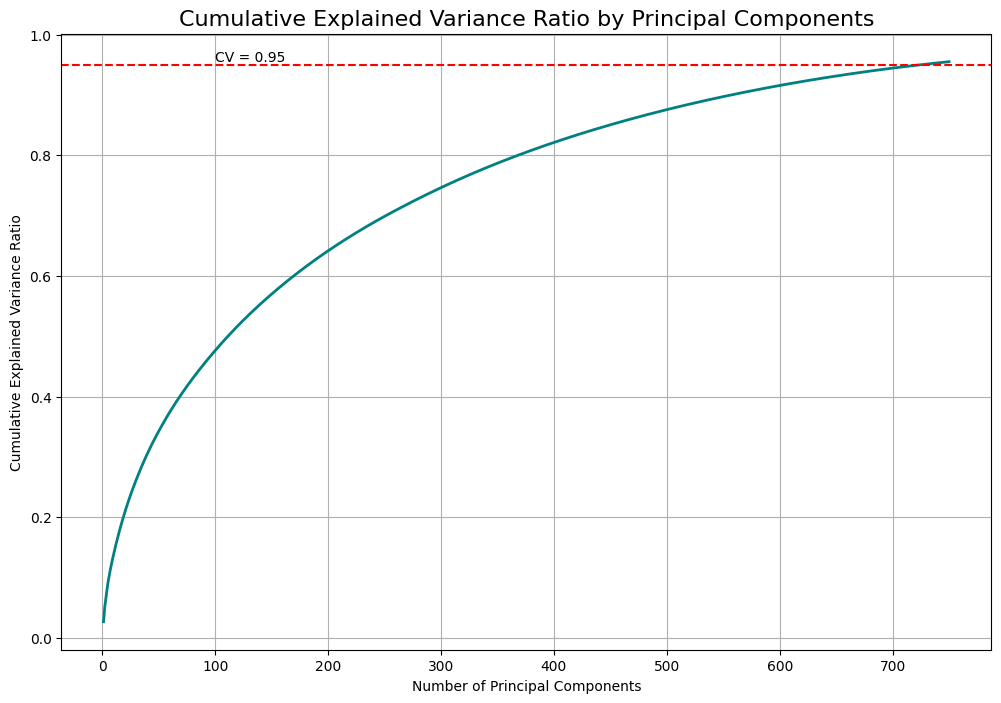

In [150]:
plt.figure(figsize = (12, 8))
plt.grid()
plt.plot(range(1, len(b) + 1), b, color = 'teal', linewidth = 2)
plt.xlabel('Number of Principal Components')
plt.ylabel('Cumulative Explained Variance Ratio')
plt.title('Cumulative Explained Variance Ratio by Principal Components', fontsize = 16)

plt.axhline(y=0.95, color='red', linestyle='--')
plt.text(100, 0.95, 'CV = 0.95', ha='left', va='bottom')

# for i, var in enumerate(b):
#     plt.text(i + 1, var, f'{var:.2f}', ha='right', va='bottom', fontsize = 12)

plt.show()

In [151]:
df = df.drop(['reviewText', 'new_reviewText'], axis=1)
df = df.reset_index(drop=True)
df

,overall,verified,reviewerID,productID
0,5,1,A30VYJQW4XWDQ6,B0011FYB5I
1,5,1,A30VYJQW4XWDQ6,B0011FYB5I
2,5,1,A28F08XFZRKIH5,B01DKQAXC0
3,3,1,A157AUOFPJQ46Q,B000X7ST9Y
4,5,1,A2USMIT2CSA08,B0091OCA86
...,...,...,...,...
4216,5,0,A3E5V5TSTAY3R9,B0006O10P4
4217,5,0,A3E5V5TSTAY3R9,B0006O10P4
4218,5,0,A281NPSIMI1C2R,B0006O10P4
4219,5,1,A3E5V5TSTAY3R9,B0006O10P4


In [152]:
label_encoder = LabelEncoder()
df['reviewerID_encoded'] = label_encoder.fit_transform(df['reviewerID'])
df['productID_encoded'] = label_encoder.fit_transform(df['productID'])
df.drop(['reviewerID', 'productID'], axis=1, inplace=True)
df

,overall,verified,reviewerID_encoded,productID_encoded
0,5,1,533,25
1,5,1,533,25
2,5,1,320,82
3,3,1,36,21
4,5,1,494,51
...,...,...,...,...
4216,5,0,623,4
4217,5,0,623,4
4218,5,0,317,4
4219,5,1,623,4


In [ ]:
df_final = pd.concat([df, pca_df], axis=1)
df_final

In [154]:
df_final.to_csv("biden2024.csv", index=False)

# TTVS

In [155]:
X = df_final.drop('verified',axis =1)
y = df_final['verified']

In [156]:
y.value_counts()

verified
1    3423
0     798
Name: count, dtype: int64

Text(0.5, 1.0, 'Label Distribution')

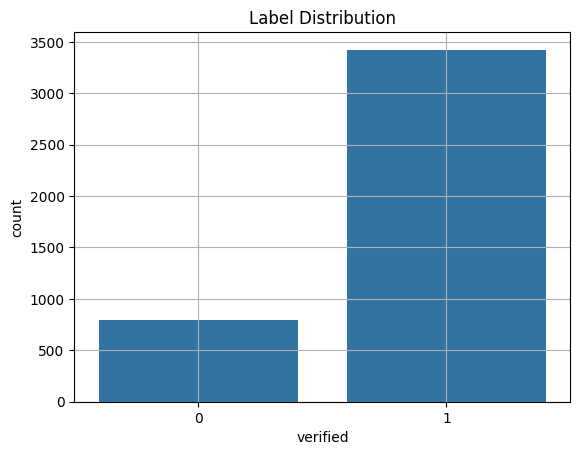

In [157]:
sns.countplot(df_final,x = y)
plt.grid()
plt.title('Label Distribution')

In [158]:
X_T,X_test,y_T,y_test =     train_test_split(X,y,test_size= 0.19,stratify=y,random_state= 4122004)
X_train,X_val,y_train,y_val =     train_test_split(X_T,y_T,test_size= 0.11,stratify=y_T,random_state= 4122004)


In [159]:
# print("X_T:", X_T)
# print("X_test:", X_test)
# print("y_T:", y_T)
# print("y_test:", y_test)
# print("X_train:", X_train)
# print("X_val:", X_val)
print("y_train:", y_train)
# print("y_val:", y_val)


y_train: 1615    1
3416    0
2101    1
1689    0
3664    0
       ..
3662    0
3826    1
2871    1
3413    0
3941    1
Name: verified, Length: 3042, dtype: int64


In [160]:
print("X_train:", X_train)

X_train:       overall  reviewerID_encoded  productID_encoded   PC1   PC2   PC3   PC4  \
1615        4                   1                 13 -0.04 -0.06 -0.06 -0.05   
3416        5                 353                 23 -0.05 -0.09 -0.05 -0.03   
2101        5                 547                 13 -0.03 -0.09 -0.05 -0.05   
1689        5                 659                 13 -0.05 -0.11  0.21 -0.16   
3664        1                 147                 39  0.06 -0.04 -0.05 -0.03   
...       ...                 ...                ...   ...   ...   ...   ...   
3662        1                 768                 39 -0.03 -0.11 -0.11 -0.09   
3826        2                 606                  5  0.10  0.04 -0.04  0.03   
2871        5                 618                 71 -0.14  0.16 -0.08  0.01   
3413        5                 150                 23 -0.04 -0.07 -0.04 -0.05   
3941        5                 253                  5  0.10 -0.07 -0.05 -0.01   

       PC5   PC6   PC7  ...  P

## ANN

In [161]:
from scikeras.wrappers import KerasClassifier
from sklearn.model_selection import GridSearchCV
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense
from tensorflow.keras.optimizers import Adam, SGD

In [162]:
X_T_Ann = X_T
X_test_Ann = X_test
y_test_Ann = y_test
X_train_Ann = X_train
X_val_Ann = X_val
y_train_Ann = y_train
y_val_Ann = y_val
y_T_Ann = y_T

In [163]:
def create_model(optimizer='adam', init='glorot_uniform'):
    model = Sequential()
    model.add(Dense(16, input_shape=(753,), activation='relu', kernel_initializer=init))
    model.add(Dense(32, activation='relu', kernel_initializer=init))
    model.add(Dense(32, activation='relu', kernel_initializer=init))
    model.add(Dense(2, activation='softmax'))
    model.compile(optimizer=optimizer, loss='sparse_categorical_crossentropy', metrics=['accuracy'])
    return model

model = KerasClassifier(model=create_model, optimizer='adam', init='glorot_uniform')

batch_size = [8, 16, 32]
epochs = [10, 20]
optimizer = ['SGD', 'adam']
init = ['glorot_uniform', 'normal', 'uniform']

param_grid = dict(batch_size=batch_size, epochs=epochs, optimizer=optimizer, init=init)

grid = GridSearchCV(estimator=model, param_grid=param_grid, n_jobs=-1, cv=3)

grid_result = grid.fit(X_train_Ann, y_train_Ann)

print(f"Best: {grid_result.best_score_} using {grid_result.best_params_}")
means = grid_result.cv_results_['mean_test_score']
stds = grid_result.cv_results_['std_test_score']
params = grid_result.cv_results_['params']

best_model = grid_result.best_estimator_.model_

best_model.fit(X_train_Ann, y_train_Ann, epochs=grid_result.best_params_['epochs'], batch_size=grid_result.best_params_['batch_size'])

best_model.save('model_Ann.keras')

Epoch 1/20
381/381 ━━━━━━━━━━━━━━━━━━━━ 3s 2ms/step - accuracy: 0.7874 - loss: 0.6445
Epoch 2/20
381/381 ━━━━━━━━━━━━━━━━━━━━ 1s 1ms/step - accuracy: 0.8019 - loss: 0.5005
Epoch 3/20
381/381 ━━━━━━━━━━━━━━━━━━━━ 1s 1ms/step - accuracy: 0.8102 - loss: 0.4619
Epoch 4/20
381/381 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - accuracy: 0.8064 - loss: 0.5347
Epoch 5/20
381/381 ━━━━━━━━━━━━━━━━━━━━ 1s 1ms/step - accuracy: 0.8253 - loss: 0.4278
Epoch 6/20
381/381 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - accuracy: 0.8315 - loss: 0.4017
Epoch 7/20
381/381 ━━━━━━━━━━━━━━━━━━━━ 1s 1ms/step - accuracy: 0.8383 - loss: 0.3991
Epoch 8/20
381/381 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - accuracy: 0.8558 - loss: 0.3618
Epoch 9/20
381/381 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - accuracy: 0.8788 - loss: 0.3133
Epoch 10/20
381/381 ━━━━━━━━━━━━━━━━━━━━ 1s 1ms/step - accuracy: 0.8975 - loss: 0.2831
Epoch 11/20
381/381 ━━━━━━━━━━━━━━━━━━━━ 1s 1ms/step - accuracy: 0.9135 - loss: 0.2294
Epoch 12/20
381/381 ━━━━━━━━━━━━━━━━━━━━ 1s 1ms/step

In [164]:
y_pred_prob_Ann = best_model.predict(X_test_Ann)
y_pred_Ann = np.argmax(y_pred_prob_Ann, axis=1)

report_ann = classification_report(y_test_Ann, y_pred_Ann)
print(f"Classification Report:\n", report_ann)

cm = pd.DataFrame(confusion_matrix(y_test, y_pred_Ann), ['Actual: Spam', 'Actual: Not Spam'], ['Predicted: Spam', 'Predicted: Not Spam'])

print('________________________________________________________')
print('Confusion matrix: ')
print(cm)

26/26 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step
Classification Report:
               precision    recall  f1-score   support

           0       0.93      0.79      0.85       152
           1       0.95      0.99      0.97       650

    accuracy                           0.95       802
   macro avg       0.94      0.89      0.91       802
weighted avg       0.95      0.95      0.95       802

________________________________________________________
Confusion matrix: 
                  Predicted: Spam  Predicted: Not Spam
Actual: Spam                  120                   32
Actual: Not Spam                9                  641


In [165]:
results_ann = best_model.evaluate(X_test_Ann, y_test_Ann)
accuracy_ann = results_ann[-1]
print(f"Artificial Neural Network Accuracy: {accuracy_ann * 100:.4f}")

26/26 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - accuracy: 0.9329 - loss: 0.2259  
Artificial Neural Network Accuracy: 94.8878


## Random Forest

In [166]:
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import RandomizedSearchCV
from sklearn.metrics import accuracy_score

In [167]:
X_T_Rf = X_T
X_test_Rf = X_test
y_test_Rf = y_test
X_train_Rf = X_train
X_val_Rf = X_val
y_train_Rf = y_train
y_val_Rf = y_val
y_T_Rf = y_T

In [168]:
# from sklearn.ensemble import RandomForestClassifier
# from sklearn.model_selection import GridSearchCV
# from sklearn.metrics import accuracy_score
# import joblib

# X_T_Rf = X_T
# X_test_Rf = X_test
# y_test_Rf = y_test
# X_train_Rf = X_train
# X_val_Rf = X_val
# y_train_Rf = y_train
# y_val_Rf = y_val
# y_T_Rf = y_T

# param_grid = {
#     'n_estimators': [50, 100, 200],
#     'max_features': ['auto', 'sqrt', 'log2'],
#     'max_depth': [None, 10, 20, 30],
#     'min_samples_split': [2, 5, 10],
#     'min_samples_leaf': [1, 2, 4],
#     'bootstrap': [True, False]
# }

# rf_classifier = RandomForestClassifier(random_state=42)

# grid_search = GridSearchCV(estimator=rf_classifier, param_grid=param_grid, 
#                            cv=3, verbose=2)

# grid_search.fit(X_train_Rf, y_train_Rf)

# print(f"Best: {grid_search.best_score_} using {grid_search.best_params_}")

# best_rf_model = grid_search.best_estimator_

# if X_test_Rf is not None and y_test_Rf is not None:
#     y_pred = best_rf_model.predict(X_test_Rf)
#     test_accuracy = accuracy_score(y_test_Rf, y_pred)
#     print(f"Test Accuracy: {test_accuracy}")

# joblib.dump(best_rf_model, 'model_Rf.pkl')

In [169]:

param_dist = {
    'n_estimators': np.arange(50, 251, 50),          
    'max_features': ['auto', 'sqrt', 'log2'],        
    'max_depth': [None, 10, 20, 30, 40, 50],          
    'min_samples_split': np.arange(2, 11),            
    'min_samples_leaf': np.arange(1, 5),              
    'bootstrap': [True, False]                        
}

rf_classifier = RandomForestClassifier(random_state=42)

random_search = RandomizedSearchCV(estimator=rf_classifier, param_distributions=param_dist, 
                                   n_iter=100, cv=3, random_state=42)

random_search.fit(X_train_Rf, y_train_Rf)

print(f"Best: {random_search.best_score_} using {random_search.best_params_}")

best_rf_model = random_search.best_estimator_

if X_test_Rf is not None and y_test_Rf is not None:
    y_pred = best_rf_model.predict(X_test_Rf)
    test_accuracy = accuracy_score(y_test_Rf, y_pred)
    print(f"Test Accuracy: {test_accuracy}")

joblib.dump(best_rf_model, 'model_Rf.pkl')

Best: 0.9582511505588429 using {'n_estimators': 250, 'min_samples_split': 4, 'min_samples_leaf': 1, 'max_features': 'sqrt', 'max_depth': None, 'bootstrap': False}
Test Accuracy: 0.9688279301745636


['model_Rf.pkl']

In [170]:
y_pred_Rf = best_rf_model.predict(X_test_Rf)

report_Rf = classification_report(y_test_Rf, y_pred_Rf)

print(f"Classification Report:\n", report_Rf)

cm = pd.DataFrame(confusion_matrix(y_test, y_pred_Rf), ['Actual: Spam', 'Actual: Not Spam'], ['Predicted: Spam', 'Predicted: Not Spam'])

print('________________________________________________________')
print('Confusion matrix: ')
print(cm)

Classification Report:
               precision    recall  f1-score   support

           0       0.90      0.94      0.92       152
           1       0.99      0.98      0.98       650

    accuracy                           0.97       802
   macro avg       0.94      0.96      0.95       802
weighted avg       0.97      0.97      0.97       802

________________________________________________________
Confusion matrix: 
                  Predicted: Spam  Predicted: Not Spam
Actual: Spam                  143                    9
Actual: Not Spam               16                  634


In [171]:
acc_rf = round(best_rf_model.score(X_test_Rf, y_test_Rf) * 100, 4)
print(f"Random Forest Accuracy: {acc_rf}" )

Random Forest Accuracy: 96.8828


## KNN

In [172]:
from sklearn.model_selection import GridSearchCV, train_test_split
from sklearn.neighbors import KNeighborsClassifier
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import accuracy_score
import joblib

In [173]:
X_T_knn = X_T
X_test_knn = X_test
y_test_knn = y_test
X_train_knn = X_train
X_val_knn = X_val
y_train_knn = y_train
y_val_knn = y_val
y_T_knn = y_T

In [174]:
knn = KNeighborsClassifier()

param_grid = {
    'n_neighbors': [3, 5, 7, 9, 11],  
    'weights': ['uniform', 'distance'],  
    'metric': ['euclidean', 'manhattan', 'minkowski']  
}

grid_search = GridSearchCV(estimator=knn, param_grid=param_grid, cv=3, n_jobs=-1, verbose=2)

grid_search.fit(X_train_knn, y_train_knn)

print(f"Best: {grid_search.best_score_} using {grid_search.best_params_}")

best_knn_model = grid_search.best_estimator_

joblib.dump(best_knn_model, 'model_knn.pkl')

Fitting 3 folds for each of 30 candidates, totalling 90 fits
Best: 0.8833004602235371 using {'metric': 'manhattan', 'n_neighbors': 3, 'weights': 'distance'}


['model_knn.pkl']

In [175]:
y_pred_knn = best_knn_model.predict(X_test_knn)

report_knn = classification_report(y_pred_knn, y_test_knn)

print(f"Classification Report:\n", report_knn)

cm = pd.DataFrame(confusion_matrix(y_test, y_pred_knn), ['Actual: Spam', 'Actual: Not Spam'], ['Predicted: Spam', 'Predicted: Not Spam'])

print('________________________________________________________')
print('Confusion matrix: ')
print(cm)

Classification Report:
               precision    recall  f1-score   support

           0       0.61      0.85      0.71       109
           1       0.98      0.91      0.94       693

    accuracy                           0.91       802
   macro avg       0.79      0.88      0.83       802
weighted avg       0.93      0.91      0.91       802

________________________________________________________
Confusion matrix: 
                  Predicted: Spam  Predicted: Not Spam
Actual: Spam                   93                   59
Actual: Not Spam               16                  634


In [176]:
acc_knn = round(best_knn_model.score(X_test_knn, y_test_knn) * 100, 4)
print(f"KNN Accuracy: {acc_knn}" )

KNN Accuracy: 90.6484


## Logistic regression

In [177]:
from sklearn.model_selection import GridSearchCV, train_test_split
from sklearn.linear_model import LogisticRegression
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import accuracy_score
import joblib

In [178]:
X_T_lr = X_T
X_test_lr = X_test
y_test_lr = y_test
X_train_lr = X_train
X_val_lr = X_val
y_train_lr = y_train
y_val_lr = y_val
y_T_lr = y_T

In [179]:
logreg = LogisticRegression()

pipe = Pipeline([
    ('scaler', StandardScaler()), 
    ('logreg', logreg)
])

param_grid = {
    'logreg__penalty': ['l1', 'l2', 'elasticnet', 'none'],  
    'logreg__C': [0.1, 1.0, 10, 100],  
    'logreg__solver': ['liblinear', 'saga']  
}

grid_search = GridSearchCV(estimator=pipe, param_grid=param_grid, cv=3, n_jobs=-1)

grid_search.fit(X_train_lr, y_train_lr)

print(f"Best: {grid_search.best_score_} using {grid_search.best_params_}")

best_logreg_model = grid_search.best_estimator_

joblib.dump(best_logreg_model, 'model_logreg.pkl')

Best: 0.9339250493096647 using {'logreg__C': 0.1, 'logreg__penalty': 'l2', 'logreg__solver': 'saga'}


['model_logreg.pkl']

In [180]:
y_pred_lr = best_logreg_model.predict(X_test_lr)

report_lr = classification_report(y_pred_lr, y_test_lr)

print(f"Classification Report:\n", report_lr)

cm = pd.DataFrame(confusion_matrix(y_test, y_pred_lr), ['Actual: Spam', 'Actual: Not Spam'], ['Predicted: Spam', 'Predicted: Not Spam'])

print('________________________________________________________')
print('Confusion matrix: ')
print(cm)

Classification Report:
               precision    recall  f1-score   support

           0       0.81      0.92      0.86       134
           1       0.98      0.96      0.97       668

    accuracy                           0.95       802
   macro avg       0.90      0.94      0.91       802
weighted avg       0.95      0.95      0.95       802

________________________________________________________
Confusion matrix: 
                  Predicted: Spam  Predicted: Not Spam
Actual: Spam                  123                   29
Actual: Not Spam               11                  639


In [181]:
y_pred_lr = best_logreg_model.predict(X_test_lr)
acc_lr = round(accuracy_score(y_test_lr, y_pred_lr) * 100, 4)
print(f"Logistic Regression Accuracy: {acc_lr}")

Logistic Regression Accuracy: 95.0125


## Decision tree

In [182]:
from sklearn.tree import DecisionTreeClassifier
param_dist = {        
    'max_features': ['auto', 'sqrt', 'log2'],        
    'max_depth': [None, 10, 20, 30, 40, 50],          
    'min_samples_split': np.arange(2, 11),            
    'min_samples_leaf': np.arange(1, 5)         
}

decision_tree = DecisionTreeClassifier(random_state = 1)

random_search = RandomizedSearchCV(estimator=decision_tree, param_distributions=param_dist, 
                                   n_iter=100, cv=3, random_state=42)

random_search.fit(X_train, y_train)

print(f"Best: {random_search.best_score_} using {random_search.best_params_}")

best_dec_tree_model = random_search.best_estimator_

if X_test is not None and y_test is not None:
    y_pred_dec_tree = best_dec_tree_model.predict(X_test)
    test_accuracy = accuracy_score(y_test, y_pred_dec_tree)
    print(f"Test Accuracy: {test_accuracy}")

joblib.dump(best_dec_tree_model, 'model_dec_tree.pkl')

Best: 0.915844838921762 using {'min_samples_split': 7, 'min_samples_leaf': 1, 'max_features': 'sqrt', 'max_depth': None}
Test Accuracy: 0.9201995012468828


['model_dec_tree.pkl']

In [183]:
y_pred_dec_tree = best_dec_tree_model.predict(X_test)

report_dec_tree = classification_report(y_pred_dec_tree, y_test)

print(f"Classification Report:\n", report_dec_tree)

cm = pd.DataFrame(confusion_matrix(y_test, y_pred_dec_tree), ['Actual: Spam', 'Actual: Not Spam'], ['Predicted: Spam', 'Predicted: Not Spam'])

print('________________________________________________________')
print('Confusion matrix: ')
print(cm)

Classification Report:
               precision    recall  f1-score   support

           0       0.78      0.79      0.79       150
           1       0.95      0.95      0.95       652

    accuracy                           0.92       802
   macro avg       0.87      0.87      0.87       802
weighted avg       0.92      0.92      0.92       802

________________________________________________________
Confusion matrix: 
                  Predicted: Spam  Predicted: Not Spam
Actual: Spam                  119                   33
Actual: Not Spam               31                  619


In [184]:
acc_dec_tree = round(accuracy_score(y_test, y_pred_dec_tree) * 100, 4)
print(f"Decision Tree Accuracy: {acc_dec_tree}")

Decision Tree Accuracy: 92.02


## LGBM

In [185]:
import lightgbm as lgb

lgbm = lgb.LGBMClassifier()

lgbm.fit(X_train, y_train)
accuracy_lgbm = lgbm.score(X_test, y_test)
print(f"Test accuracy: {accuracy_lgbm * 100:.4f}")

[LightGBM] [Info] Number of positive: 2467, number of negative: 575
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.020312 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 191556
[LightGBM] [Info] Number of data points in the train set: 3042, number of used features: 753
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.810980 -> initscore=1.456388
[LightGBM] [Info] Start training from score 1.456388
Test accuracy: 97.5062


In [216]:
y_pred_lgbm = lgbm.predict(X_test)

report = classification_report(y_test, y_pred_lgbm)
print("Classification Report:")
print(report)

print('________________________________________________________')
cm = pd.DataFrame(confusion_matrix(y_test, y_pred_lgbm),
                  ['Actual: Spam', 'Actual: Not Spam'], ['Predicted: Spam', 'Predicted: Not Spam'])

print(cm)

Classification Report:
              precision    recall  f1-score   support

           0       0.92      0.95      0.94       152
           1       0.99      0.98      0.98       650

    accuracy                           0.98       802
   macro avg       0.96      0.96      0.96       802
weighted avg       0.98      0.98      0.98       802

________________________________________________________
                  Predicted: Spam  Predicted: Not Spam
Actual: Spam                  144                    8
Actual: Not Spam               12                  638


## Stacking Ensemble

In [187]:
from sklearn.ensemble import GradientBoostingClassifier
from sklearn.svm import SVC
from sklearn.neural_network import MLPClassifier
import xgboost as xgb

In [ ]:
from sklearn.ensemble import StackingClassifier

base_models = [
    ('logreg', best_logreg_model),
    ('knn', best_knn_model),
    ('dec_tree', best_dec_tree_model)
]
stacking_classifier = StackingClassifier(estimators=base_models, 
                                         final_estimator=GradientBoostingClassifier())

stacking_classifier.fit(X_train, y_train)
y_pred_stacked = stacking_classifier.predict(X_test)

In [217]:
report = classification_report(y_test, y_pred_stacked)
print("Classification Report:")
print(report)
print('________________________________________________________')
cm = pd.DataFrame(confusion_matrix(y_test, y_pred_stacked),
                  ['Actual: Spam', 'Actual: Not Spam'], ['Predicted: Spam', 'Predicted: Not Spam'])

print(cm)

Classification Report:
              precision    recall  f1-score   support

           0       0.88      0.89      0.89       152
           1       0.98      0.97      0.97       650

    accuracy                           0.96       802
   macro avg       0.93      0.93      0.93       802
weighted avg       0.96      0.96      0.96       802

________________________________________________________
                  Predicted: Spam  Predicted: Not Spam
Actual: Spam                  136                   16
Actual: Not Spam               18                  632


## Voting Classifier

In [189]:
from sklearn.ensemble import VotingClassifier
def get_voting():
    models = list()
    models.append(('Decision Tree', best_dec_tree_model))
    models.append(('K Nearest Neighbors', best_knn_model))
    models.append(('Logistic Regression', best_logreg_model))
    
    ensemble = VotingClassifier(estimators=models, voting='hard')
    return ensemble

voting = get_voting()
voting.fit(X_train, y_train)
y_pred_voting = voting.predict(X_test)

In [190]:
report = classification_report(y_test, y_pred_voting)
print("Classification Report:")
print(report)

cm = pd.DataFrame(confusion_matrix(y_test, y_pred_voting),
                  ['Actual: Spam', 'Actual: Not Spam'], ['Predicted: Spam', 'Predicted: Not Spam'])

print(cm)

Classification Report:
              precision    recall  f1-score   support

           0       0.91      0.80      0.85       152
           1       0.96      0.98      0.97       650

    accuracy                           0.95       802
   macro avg       0.93      0.89      0.91       802
weighted avg       0.95      0.95      0.95       802

                  Predicted: Spam  Predicted: Not Spam
Actual: Spam                  122                   30
Actual: Not Spam               12                  638


## Adaboost

## Adaboost

In [204]:
from sklearn.ensemble import AdaBoostClassifier

estimator = DecisionTreeClassifier(max_depth=1)

adabussy = AdaBoostClassifier(
    estimator= estimator,
    n_estimators=500,
    random_state=42
)

adabussy.fit(X_train, y_train)
y_pred_ada = adabussy.predict(X_test)

In [205]:
report = classification_report(y_test, y_pred_ada)
print("Classification Report:")
print(report)

cm = pd.DataFrame(confusion_matrix(y_test, y_pred_ada),
                  ['Actual: Spam', 'Actual: Not Spam'], ['Predicted: Spam', 'Predicted: Not Spam'])

print(cm)

Classification Report:
              precision    recall  f1-score   support

           0       0.95      0.91      0.93       152
           1       0.98      0.99      0.98       650

    accuracy                           0.97       802
   macro avg       0.97      0.95      0.96       802
weighted avg       0.97      0.97      0.97       802

                  Predicted: Spam  Predicted: Not Spam
Actual: Spam                  138                   14
Actual: Not Spam                7                  643


## Resultats

In [ ]:
classifiers = [best_rf_model, lgbm, best_dec_tree_model, 
               best_knn_model, best_logreg_model, stacking_classifier, voting, adabussy]

stratified_kfold = StratifiedKFold(n_splits=7)

cv_results = []
cv_results.append(cross_val_score(best_rf_model, X, y = y, scoring = "accuracy", cv = stratified_kfold))
cv_results.append(cross_val_score(lgbm, X, y = y, scoring = "accuracy", cv = stratified_kfold))
cv_results.append(cross_val_score(best_dec_tree_model, X, y = y, scoring = "accuracy", cv = stratified_kfold))
cv_results.append(cross_val_score(best_knn_model, X, y = y, scoring = "accuracy", cv = stratified_kfold))
cv_results.append(cross_val_score(best_logreg_model, X, y = y, scoring = "accuracy", cv = stratified_kfold))
cv_results.append(cross_val_score(stacking_classifier, X, y = y, scoring = "accuracy", cv = stratified_kfold))
cv_results.append(cross_val_score(voting, X, y = y, scoring = "accuracy", cv = stratified_kfold))
cv_results.append(cross_val_score(adabussy, X, y = y, scoring = "accuracy", cv = stratified_kfold))

cv_means = []
cv_std = []
for cv_result in cv_results:
    cv_means.append(cv_result.mean())
    cv_std.append(cv_result.std())

cv_max = np.max(cv_results, axis=1)

cv_res = pd.DataFrame({"CrossValMeans": cv_means,
                       "CrossValMax": cv_max,
                       "CrossValErrors": cv_std, 
                       "Algorithm": ['Random Forest', 
                                     'Light Gradient Boosting Machine',
                                     'Decision Tree',
                                     'K Nearest Neighbors',
                                     'Logistic Regression',
                                     'Stacking Ensemble',
                                     'Voting Ensemble',
                                     'Adaboost']})

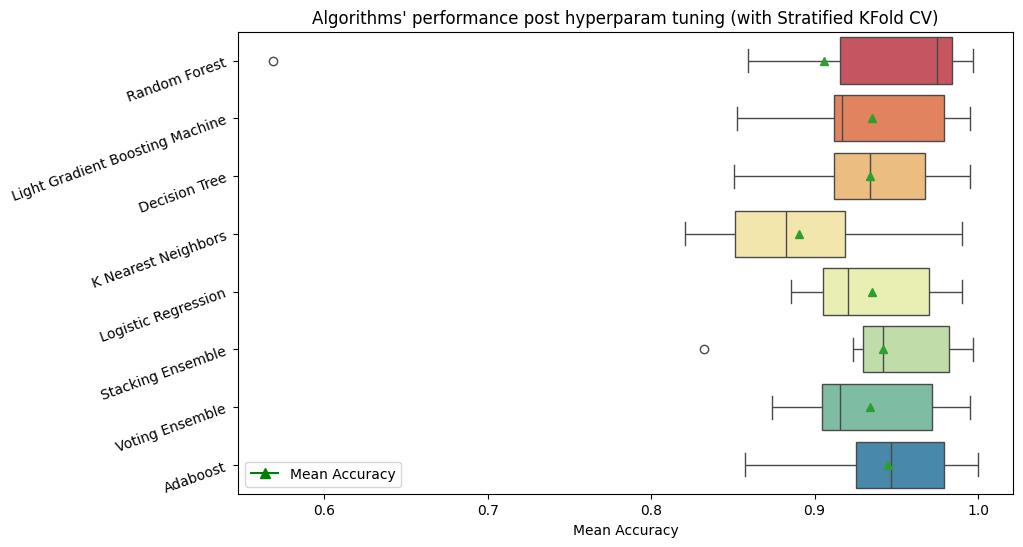

In [207]:
plt.figure(figsize=(10, 6))
sns.boxplot(data=cv_results, orient='h', palette='Spectral', showmeans = True)
plt.yticks(range(len(classifiers)), ['Random Forest', 
                                     'Light Gradient Boosting Machine',
                                     'Decision Tree',
                                     'K Nearest Neighbors',
                                     'Logistic Regression',
                                     'Stacking Ensemble',
                                     'Voting Ensemble',
                                     'Adaboost'], rotation = 20)
plt.xlabel("Mean Accuracy")
plt.title("Algorithms' performance post hyperparam tuning (with Stratified KFold CV)")
plt.legend(handles=[plt.Line2D([], [], color='green', marker='^', markersize=7, linestyle= '-', label='Mean Accuracy')], loc = 'best')


plt.show()

In [209]:
classifiers_name = ['Random Forest', 'LGBM', 'Decision Tree', 'KNN', 
                    'Logistic Regression', 'Stacking Ensemble', 'Voting Ensemble', 'Adaboost']
for i in range(len(cv_means)):
    print(f"{classifiers_name[i]} mean accuracy: {round(cv_means[i] * 100, 4)}")

Random Forest mean accuracy: 90.571
LGBM mean accuracy: 93.5323
Decision Tree mean accuracy: 93.4139
KNN mean accuracy: 89.0547
Logistic Regression mean accuracy: 93.5323
Stacking Ensemble mean accuracy: 94.2194
Voting Ensemble mean accuracy: 93.3902
Adaboost mean accuracy: 94.48


###     =>  Le Winner: Adaboost

## Learning Curve

<module 'matplotlib.pyplot' from 'C:\\Users\\DELL\\AppData\\Roaming\\Python\\Python312\\site-packages\\matplotlib\\pyplot.py'>

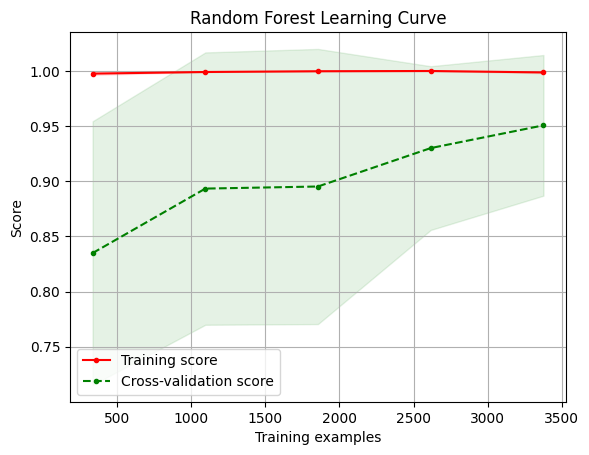

In [196]:
kfold = KFold(n_splits = 5)

def plot_learning_curve(estimator, title, X, y, ylim=None, cv=None, n_jobs=-1, train_sizes=np.linspace(.1, 1.0, 5)):
    plt.figure()
    plt.title(title)
    if ylim is not None:
        plt.ylim(*ylim)
    plt.xlabel("Training examples")
    plt.ylabel("Score")
    train_sizes, train_scores, test_scores = learning_curve(estimator, X, y, 
                                                            cv=cv,
                                                            n_jobs=n_jobs,
                                                            train_sizes=train_sizes)
    train_scores_mean = np.mean(train_scores, axis=1)
    train_scores_std = np.std(train_scores, axis=1)
    test_scores_mean = np.mean(test_scores, axis=1)
    test_scores_std = np.std(test_scores, axis=1)
    plt.grid()

    plt.fill_between(train_sizes, train_scores_mean - train_scores_std,
                     train_scores_mean + train_scores_std, alpha=0.1,
                     color="r")
    plt.fill_between(train_sizes, test_scores_mean - test_scores_std,
                     test_scores_mean + test_scores_std, alpha=0.1, color="g")
    plt.plot(train_sizes, train_scores_mean, '.-', color="r",
             label="Training score")
    plt.plot(train_sizes, test_scores_mean, '.-', color="g", linestyle = '--',
             label="Cross-validation score")
    plt.legend(loc="best")
    return plt

plot_learning_curve(best_rf_model, "Random Forest Learning Curve", X, y, cv=kfold)

<module 'matplotlib.pyplot' from 'C:\\Users\\DELL\\AppData\\Roaming\\Python\\Python312\\site-packages\\matplotlib\\pyplot.py'>

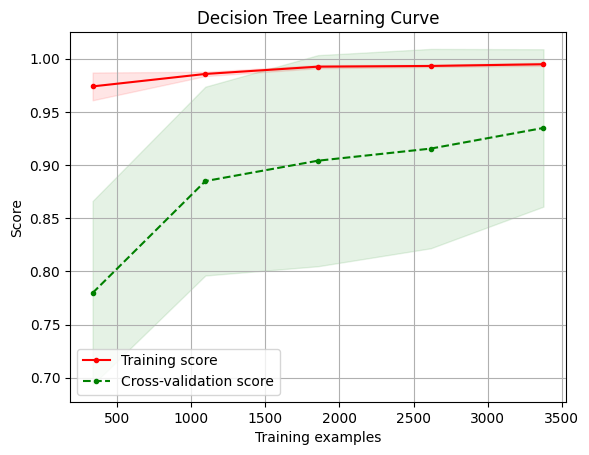

In [197]:
plot_learning_curve(best_dec_tree_model, "Decision Tree Learning Curve", X, y, cv=kfold)

<module 'matplotlib.pyplot' from 'C:\\Users\\DELL\\AppData\\Roaming\\Python\\Python312\\site-packages\\matplotlib\\pyplot.py'>

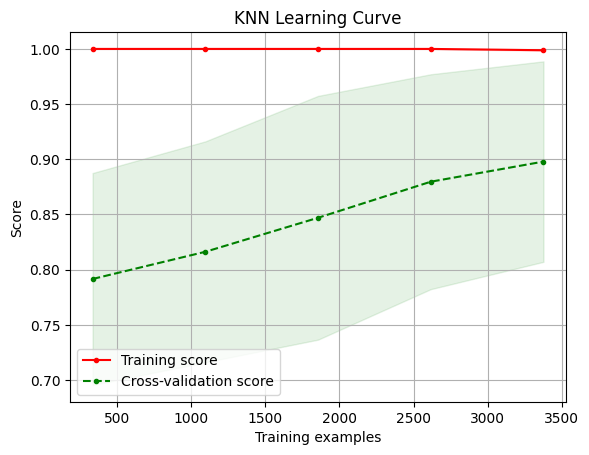

In [198]:
plot_learning_curve(best_knn_model, "KNN Learning Curve", X, y, cv=kfold)

<module 'matplotlib.pyplot' from 'C:\\Users\\DELL\\AppData\\Roaming\\Python\\Python312\\site-packages\\matplotlib\\pyplot.py'>

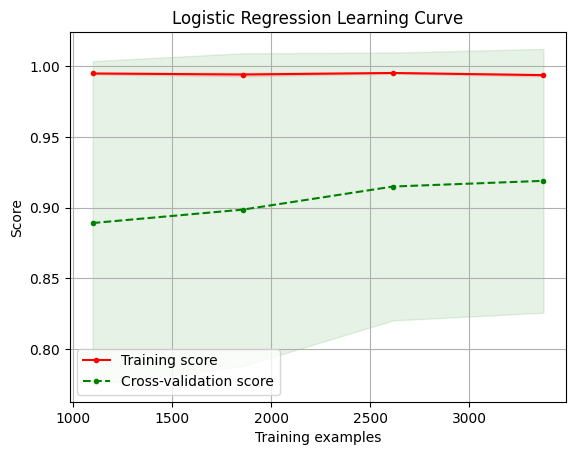

In [199]:
plot_learning_curve(best_logreg_model, "Logistic Regression Learning Curve", X, y, cv=kfold)

No Skill: ROC AUC=0.500


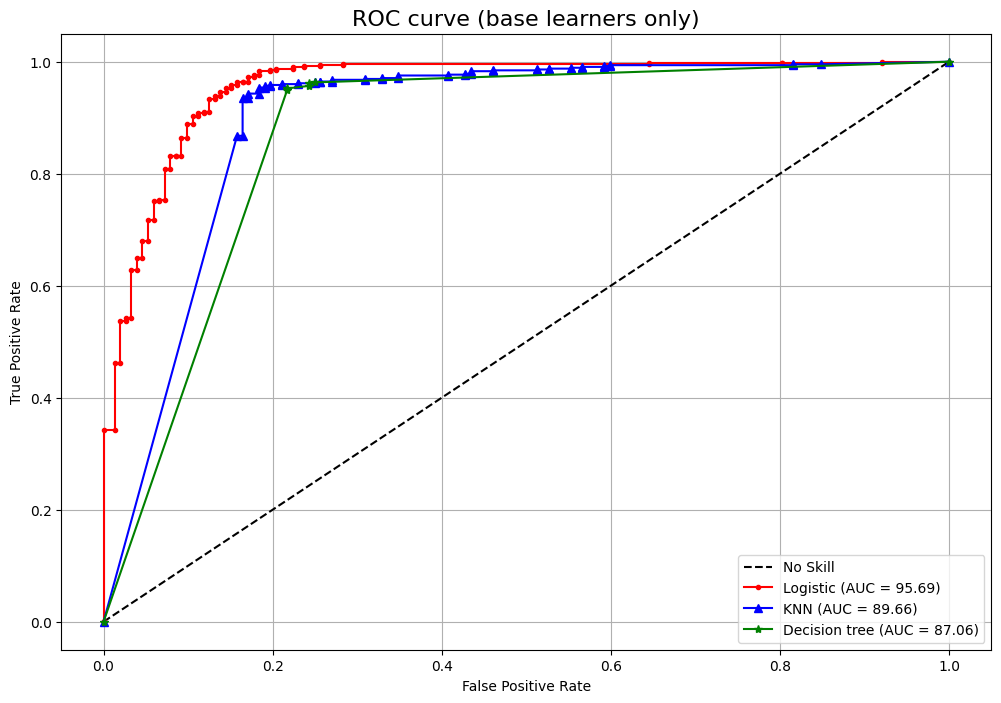

In [200]:
from sklearn.metrics import roc_auc_score, roc_curve

ns_probs = [0 for _ in range(len(y_test))]
ns_auc = roc_auc_score(y_test, ns_probs)
print('No Skill: ROC AUC=%.3f' % (ns_auc))
ns_fpr, ns_tpr, _ = roc_curve(y_test, ns_probs)

y_scores_lr = best_logreg_model.decision_function(X_test)
lr_fpr, lr_tpr, thresholds = roc_curve(y_test, y_scores_lr)
lr_auc = roc_auc_score(y_test, y_scores_lr)

y_scores_knn = best_knn_model.predict_proba(X_test)[:, 1]
knn_fpr, knn_tpr, thresholds = roc_curve(y_test, y_scores_knn)
knn_auc = roc_auc_score(y_test, y_scores_knn)

y_scores_tree = best_dec_tree_model.predict_proba(X_test)[:, 1]
tree_fpr, tree_tpr, thresholds = roc_curve(y_test, y_scores_tree)
tree_auc = roc_auc_score(y_test, y_scores_tree)

# y_scores_rf = best_rf_model.predict_proba(X_test)[:, 1]
# rf_fpr, rf_tpr, thresholds = roc_curve(y_test, y_scores_rf)
# rf_auc = roc_auc_score(y_test, y_scores_rf)

plt.figure(figsize=(12,8))
plt.title('ROC curve (base learners only)', fontsize = 16)

plt.plot(ns_fpr, ns_tpr, linestyle='--', label='No Skill', color = 'black')
plt.plot(lr_fpr, lr_tpr, marker='.', label='Logistic (AUC = {:.2f})'.format(lr_auc*100), color = 'red')
plt.plot(knn_fpr, knn_tpr, label='KNN (AUC = {:.2f})'.format(knn_auc*100), color = 'blue', marker = '^')
plt.plot(tree_fpr, tree_tpr, label='Decision tree (AUC = {:.2f})'.format(tree_auc*100), color = 'green', marker= '*')
# plt.plot(rf_fpr, rf_tpr, label='Random Forest (AUC = {:.2f})'.format(tree_auc*100), color = 'purple', marker= 'o')

plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.legend()
plt.grid()
plt.show()

## Lazy Classifier - J4F

In [201]:
from lazypredict.Supervised import LazyClassifier

In [202]:
lazy = LazyClassifier(verbose=1, 
                      ignore_warnings=True,
                      custom_metric=None)
models = lazy.fit(X_train, X_test, y_train, y_test)

  0%|          | 0/31 [00:00<?, ?it/s]

  3%|▎         | 1/31 [00:12<06:06, 12.20s/it]

{'Model': 'AdaBoostClassifier', 'Accuracy': 0.9002493765586035, 'Balanced Accuracy': 0.7948076923076923, 'ROC AUC': 0.7948076923076923, 'F1 Score': 0.89523996660578, 'Time taken': 12.201644897460938}


  6%|▋         | 2/31 [00:59<15:48, 32.72s/it]

{'Model': 'BaggingClassifier', 'Accuracy': 0.9513715710723192, 'Balanced Accuracy': 0.9397570850202429, 'ROC AUC': 0.9397570850202429, 'F1 Score': 0.9522310491777338, 'Time taken': 47.07347917556763}


 10%|▉         | 3/31 [00:59<08:20, 17.87s/it]

{'Model': 'BernoulliNB', 'Accuracy': 0.8778054862842892, 'Balanced Accuracy': 0.7381174089068826, 'ROC AUC': 0.7381174089068825, 'F1 Score': 0.8680413285828882, 'Time taken': 0.20013070106506348}


 13%|█▎        | 4/31 [01:29<10:07, 22.49s/it]

{'Model': 'CalibratedClassifierCV', 'Accuracy': 0.9251870324189526, 'Balanced Accuracy': 0.827834008097166, 'ROC AUC': 0.827834008097166, 'F1 Score': 0.9206359948162159, 'Time taken': 29.558107137680054}


 23%|██▎       | 7/31 [01:35<03:35,  8.98s/it]

{'Model': 'DecisionTreeClassifier', 'Accuracy': 0.928927680798005, 'Balanced Accuracy': 0.8729858299595141, 'ROC AUC': 0.8729858299595141, 'F1 Score': 0.9280878548407632, 'Time taken': 6.583353042602539}
{'Model': 'DummyClassifier', 'Accuracy': 0.8104738154613467, 'Balanced Accuracy': 0.5, 'ROC AUC': 0.5, 'F1 Score': 0.7256308265149798, 'Time taken': 0.11247372627258301}


 26%|██▌       | 8/31 [01:36<02:29,  6.50s/it]

{'Model': 'ExtraTreeClassifier', 'Accuracy': 0.9376558603491272, 'Balanced Accuracy': 0.8708097165991904, 'ROC AUC': 0.8708097165991904, 'F1 Score': 0.9357427452602172, 'Time taken': 0.18436050415039062}


 35%|███▌      | 11/31 [01:37<00:56,  2.82s/it]

{'Model': 'ExtraTreesClassifier', 'Accuracy': 0.9538653366583542, 'Balanced Accuracy': 0.9085323886639676, 'ROC AUC': 0.9085323886639677, 'F1 Score': 0.9530632267278455, 'Time taken': 1.5036001205444336}
{'Model': 'GaussianNB', 'Accuracy': 0.7144638403990025, 'Balanced Accuracy': 0.7230364372469635, 'ROC AUC': 0.7230364372469635, 'F1 Score': 0.742941171437396, 'Time taken': 0.16823697090148926}


 39%|███▊      | 12/31 [01:37<00:41,  2.20s/it]

{'Model': 'KNeighborsClassifier', 'Accuracy': 0.844139650872818, 'Balanced Accuracy': 0.5963765182186235, 'ROC AUC': 0.5963765182186235, 'F1 Score': 0.8005469631636771, 'Time taken': 0.24847078323364258}


 42%|████▏     | 13/31 [01:38<00:33,  1.86s/it]

{'Model': 'LabelPropagation', 'Accuracy': 0.9451371571072319, 'Balanced Accuracy': 0.9611133603238866, 'ROC AUC': 0.9611133603238866, 'F1 Score': 0.9474560184993405, 'Time taken': 0.8871021270751953}


 45%|████▌     | 14/31 [01:40<00:29,  1.75s/it]

{'Model': 'LabelSpreading', 'Accuracy': 0.9451371571072319, 'Balanced Accuracy': 0.9611133603238866, 'ROC AUC': 0.9611133603238866, 'F1 Score': 0.9474560184993405, 'Time taken': 1.4397168159484863}


 48%|████▊     | 15/31 [01:40<00:23,  1.45s/it]

{'Model': 'LinearDiscriminantAnalysis', 'Accuracy': 0.9214463840399002, 'Balanced Accuracy': 0.8582894736842105, 'ROC AUC': 0.8582894736842105, 'F1 Score': 0.920301381799054, 'Time taken': 0.6842832565307617}


 55%|█████▍    | 17/31 [01:47<00:28,  2.05s/it]

{'Model': 'LinearSVC', 'Accuracy': 0.9413965087281796, 'Balanced Accuracy': 0.8882388663967611, 'ROC AUC': 0.888238866396761, 'F1 Score': 0.9403776123299658, 'Time taken': 6.238025665283203}
{'Model': 'LogisticRegression', 'Accuracy': 0.9513715710723192, 'Balanced Accuracy': 0.8943927125506073, 'ROC AUC': 0.8943927125506073, 'F1 Score': 0.9499538603036737, 'Time taken': 0.1874244213104248}


 61%|██████▏   | 19/31 [01:47<00:13,  1.09s/it]

{'Model': 'NearestCentroid', 'Accuracy': 0.9251870324189526, 'Balanced Accuracy': 0.8379149797570851, 'ROC AUC': 0.8379149797570851, 'F1 Score': 0.9216849238853053, 'Time taken': 0.12874245643615723}


 68%|██████▊   | 21/31 [01:48<00:06,  1.51it/s]

{'Model': 'PassiveAggressiveClassifier', 'Accuracy': 0.9451371571072319, 'Balanced Accuracy': 0.905668016194332, 'ROC AUC': 0.9056680161943319, 'F1 Score': 0.9448555502858397, 'Time taken': 0.30629444122314453}
{'Model': 'Perceptron', 'Accuracy': 0.956359102244389, 'Balanced Accuracy': 0.9226720647773279, 'ROC AUC': 0.922672064777328, 'F1 Score': 0.9560778150473328, 'Time taken': 0.19711852073669434}


 71%|███████   | 22/31 [01:48<00:06,  1.43it/s]

{'Model': 'QuadraticDiscriminantAnalysis', 'Accuracy': 0.9014962593516209, 'Balanced Accuracy': 0.7451720647773279, 'ROC AUC': 0.7451720647773279, 'F1 Score': 0.8880521997903217, 'Time taken': 0.7925734519958496}


 77%|███████▋  | 24/31 [02:01<00:21,  3.09s/it]

{'Model': 'RandomForestClassifier', 'Accuracy': 0.970074812967581, 'Balanced Accuracy': 0.9538157894736843, 'ROC AUC': 0.9538157894736841, 'F1 Score': 0.9701495528528145, 'Time taken': 12.841294765472412}
{'Model': 'RidgeClassifier', 'Accuracy': 0.9226932668329177, 'Balanced Accuracy': 0.8565384615384615, 'ROC AUC': 0.8565384615384616, 'F1 Score': 0.9212390741510784, 'Time taken': 0.19304966926574707}


 81%|████████  | 25/31 [02:02<00:14,  2.35s/it]

{'Model': 'RidgeClassifierCV', 'Accuracy': 0.9214463840399002, 'Balanced Accuracy': 0.8557692307692308, 'ROC AUC': 0.8557692307692308, 'F1 Score': 0.9200806292933584, 'Time taken': 0.6281514167785645}


 84%|████████▍ | 26/31 [02:03<00:08,  1.77s/it]

{'Model': 'SGDClassifier', 'Accuracy': 0.9177057356608479, 'Balanced Accuracy': 0.8055769230769231, 'ROC AUC': 0.8055769230769231, 'F1 Score': 0.9114558281595715, 'Time taken': 0.41759777069091797}


 87%|████████▋ | 27/31 [02:05<00:08,  2.10s/it]

{'Model': 'SVC', 'Accuracy': 0.9501246882793017, 'Balanced Accuracy': 0.8759817813765183, 'ROC AUC': 0.8759817813765182, 'F1 Score': 0.9476199833028901, 'Time taken': 2.8626086711883545}


 97%|█████████▋| 30/31 [02:12<00:02,  2.11s/it]

{'Model': 'XGBClassifier', 'Accuracy': 0.9750623441396509, 'Balanced Accuracy': 0.959412955465587, 'ROC AUC': 0.959412955465587, 'F1 Score': 0.9750623441396509, 'Time taken': 6.327361822128296}
[LightGBM] [Info] Number of positive: 2467, number of negative: 575
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.021321 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 191556
[LightGBM] [Info] Number of data points in the train set: 3042, number of used features: 753
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.810980 -> initscore=1.456388
[LightGBM] [Info] Start training from score 1.456388


100%|██████████| 31/31 [02:20<00:00,  4.52s/it]

{'Model': 'LGBMClassifier', 'Accuracy': 0.9763092269326683, 'Balanced Accuracy': 0.9652226720647773, 'ROC AUC': 0.9652226720647773, 'F1 Score': 0.9763975811603021, 'Time taken': 7.983128070831299}


In [215]:
models

(                               Accuracy  Balanced Accuracy  ROC AUC  F1 Score  \
 Model                                                                           
 LGBMClassifier                     0.98               0.97     0.97      0.98   
 LabelPropagation                   0.95               0.96     0.96      0.95   
 LabelSpreading                     0.95               0.96     0.96      0.95   
 XGBClassifier                      0.98               0.96     0.96      0.98   
 RandomForestClassifier             0.97               0.95     0.95      0.97   
 BaggingClassifier                  0.95               0.94     0.94      0.95   
 Perceptron                         0.96               0.92     0.92      0.96   
 ExtraTreesClassifier               0.95               0.91     0.91      0.95   
 PassiveAggressiveClassifier        0.95               0.91     0.91      0.94   
 LogisticRegression                 0.95               0.89     0.89      0.95   
 LinearSVC      